# Carbon Chain Take-Home Assignment



## Import libraries and data

Initial cleaning in this [google sheet](https://docs.google.com/spreadsheets/d/1A87k66aR_L3IMwV6_brB1bz7GjCYuMyuawrE6eMyODg/edit#gid=1854661490) to:
* remove extraneous header rows
* clean column names

In [1]:
# Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set default figure size
plt.rc("figure", figsize=(10, 6))
plt.rc("font", size=10)

In [2]:
#Import yearly reports
df_2018 = pd.read_csv('cleaned_2018_df.csv').reset_index(drop=True)
df_2019 = pd.read_csv('cleaned_2019_df.csv').reset_index(drop=True)
df_2020 = pd.read_csv('cleaned_2020_df.csv').reset_index(drop=True)
df_2021 = pd.read_csv('cleaned_2021_df.csv').reset_index(drop=True)

# Consolidate files into one unified df
df = df_2018.append(df_2019, ignore_index = True)
df = df.append(df_2020, ignore_index = True)
df = df.append(df_2021, ignore_index = True)

In [3]:
df.head()

,imo_number,name,ship_type,reporting_period,technical_efficiency,port_of_registry,home_port,ice_class,doc_issue_date,doc_expiry_date,...,fuel_consumption_per_transport_work_(pax)_on_laden_voyages,fuel_consumption_per_transport_work_(freight)_on_laden_voyages,co₂_emissions_per_distance_on_laden_voyages,co₂_emissions_per_transport_work_(mass)_on_laden_voyages,co₂_emissions_per_transport_work_(volume)_on_laden_voyages,co₂_emissions_per_transport_work_(dwt)_on_laden_voyages,co₂_emissions_per_transport_work_(pax)_on_laden_voyages,co₂_emissions_per_transport_work_(freight)_on_laden_voyages,additional_information_to_facilitate_the_understanding_of_the_reported_average_operational_energy_efficiency_indicators,average_density_of_the_cargo_transported
0,5383304,ASTORIA,Passenger ship,2018,Not Applicable,NaN,NaN,NaN,05/02/2019,30/06/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6417097,MARCO POLO,Passenger ship,2018,Not Applicable,NaN,NaN,IC,05/02/2019,30/06/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6511128,RED STAR 1,Ro-pax ship,2018,EIV (45.57 gCO₂/t·nm),NaN,NaN,NaN,30/04/2019,30/06/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6602898,OCEAN MAJESTY,Passenger ship,2018,EIV (31.73 gCO₂/t·nm),Madeira,NaN,NaN,06/05/2019,30/06/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6703343,EQUALITY,Other ship types,2018,Not Applicable,Beirut,NaN,NaN,30/06/2019,30/06/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Data coverage check

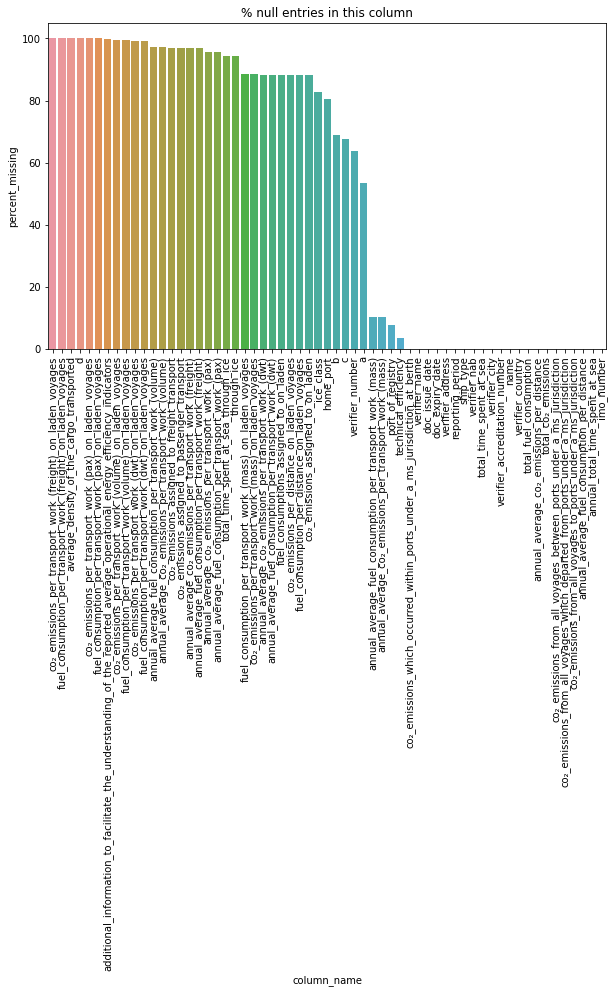

In [4]:
# Coverage check for missing values
percent_missing = df.isnull().sum() * 100 / len(df)
missing_values = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

missing_values = missing_values.sort_values('percent_missing',ascending=False).reset_index(drop=True)

# Plot
sns.barplot(data=missing_values,x = 'column_name',y='percent_missing') # create bar plot
plt.xticks(rotation=90,size=10) # tick rotation
plt.title('% null entries in this column')# add title
plt.show()

## Q1: How many ships of each type are there?

**Method**
1. Define unique 'ships' using imo_number as ID
2. Count unique ships by 'ship_type'
3. Check for yearly variation

**Takeaways**
* 18,690 total ships
* “Bulk carrier” ships account for ~⅓ of all ships
* Multiple ships may have the same name, imo_number is more unique
* No composition shift over time

### Define 'ships' and count by ship_type

In [5]:
# Metric: ships
# Definition: unique imo_number. Note: 'name' is not reliable as difference ship types have the same name
# Groupby: ship_type

q1_df = df.groupby('ship_type')\
            .agg(ships = ('imo_number','nunique'))\
            .sort_values(by='ships', ascending=False)\
            .reset_index()

# Extra: Define % of total
q1_df['share_of_total'] = q1_df['ships'] / q1_df['ships'].sum()

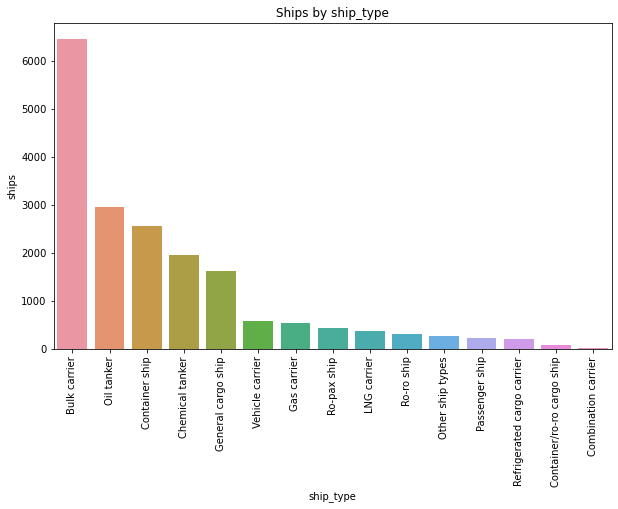

In [6]:
# Plot
sns.barplot(data=q1_df,x = 'ship_type',y='ships')
plt.xticks(rotation=90,size=10) # tick marks
plt.title('Ships by ship_type')# plot title
plt.show()

In [7]:
# Print total number of ships
q1_df.ships.sum()

18690

In [8]:
# Print table
q1_df

,ship_type,ships,share_of_total
0,Bulk carrier,6462,0.345746
1,Oil tanker,2950,0.157838
2,Container ship,2568,0.137400
3,Chemical tanker,1969,0.105350
4,General cargo ship,1633,0.087373
5,Vehicle carrier,588,0.031461
6,Gas carrier,538,0.028785
7,Ro-pax ship,441,0.023596
8,LNG carrier,385,0.020599
9,Ro-ro ship,325,0.017389


### ship_type composition over time

#### By year, by ship_type

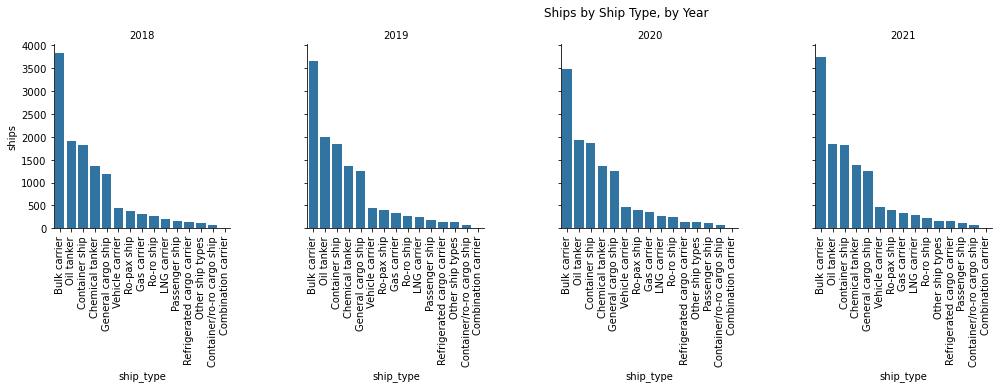

In [9]:
q1_by_year = df.groupby(['reporting_period','ship_type']).agg(ships = ('imo_number','nunique')).sort_values(by = ['reporting_period', 'ships'], ascending = [True, False]).reset_index()

# Plot
g = sns.FacetGrid(q1_by_year, col="reporting_period",col_wrap=5,sharex=False,size=3.5)
g.map_dataframe(sns.barplot, x="ship_type",y='ships')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Ships by Ship Type, by Year',y=1.05)
[plt.setp(ax.get_xticklabels(), rotation=90,size=10) for ax in g.axes.flat]
plt.show()

### Verify ID: imo_number vs. name

Which ID is the more unique value per ship?

In [10]:
df.groupby('name').agg(count = ('imo_number','count')).sort_values('count',ascending=False).reset_index().head()

,name,count
0,AURORA,14
1,CHRISTINA,13
2,MARIA,13
3,SANTA BARBARA,13
4,ENDURANCE,12


In [11]:
df[df['name'] == 'AURORA'].head()

,imo_number,name,ship_type,reporting_period,technical_efficiency,port_of_registry,home_port,ice_class,doc_issue_date,doc_expiry_date,...,fuel_consumption_per_transport_work_(pax)_on_laden_voyages,fuel_consumption_per_transport_work_(freight)_on_laden_voyages,co₂_emissions_per_distance_on_laden_voyages,co₂_emissions_per_transport_work_(mass)_on_laden_voyages,co₂_emissions_per_transport_work_(volume)_on_laden_voyages,co₂_emissions_per_transport_work_(dwt)_on_laden_voyages,co₂_emissions_per_transport_work_(pax)_on_laden_voyages,co₂_emissions_per_transport_work_(freight)_on_laden_voyages,additional_information_to_facilitate_the_understanding_of_the_reported_average_operational_energy_efficiency_indicators,average_density_of_the_cargo_transported
1053,9169524,AURORA,Passenger ship,2018,EIV (14.29 gCO₂/t·nm),Hamilton,Southampton,NaN,01/08/2019,30/06/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1913,9234989,AURORA,Container ship,2018,EIV (37.15 gCO₂/t·nm),Saint John's,NaN,IA,11/12/2019,30/06/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2306,9255579,AURORA,General cargo ship,2018,EIV (23.1 gCO₂/t·nm),TURKU,NaN,IA,20/02/2020,30/06/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13279,9169524,AURORA,Passenger ship,2019,EIV (14.29 gCO₂/t·nm),Hamilton,Southampton,NaN,12/03/2020,30/06/2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13436,9187497,AURORA,Chemical tanker,2019,EIV (10.74 gCO₂/t·nm),Majuro,NaN,NaN,01/05/2020,30/06/2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'AURORA' is the name of multiple, different ships.

When the ship is the same -- say for different time periods -- the imo_number and the ship_type are the same.

In [12]:
df[df['imo_number'] == 9169524]

,imo_number,name,ship_type,reporting_period,technical_efficiency,port_of_registry,home_port,ice_class,doc_issue_date,doc_expiry_date,...,fuel_consumption_per_transport_work_(pax)_on_laden_voyages,fuel_consumption_per_transport_work_(freight)_on_laden_voyages,co₂_emissions_per_distance_on_laden_voyages,co₂_emissions_per_transport_work_(mass)_on_laden_voyages,co₂_emissions_per_transport_work_(volume)_on_laden_voyages,co₂_emissions_per_transport_work_(dwt)_on_laden_voyages,co₂_emissions_per_transport_work_(pax)_on_laden_voyages,co₂_emissions_per_transport_work_(freight)_on_laden_voyages,additional_information_to_facilitate_the_understanding_of_the_reported_average_operational_energy_efficiency_indicators,average_density_of_the_cargo_transported
1053,9169524,AURORA,Passenger ship,2018,EIV (14.29 gCO₂/t·nm),Hamilton,Southampton,NaN,01/08/2019,30/06/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13279,9169524,AURORA,Passenger ship,2019,EIV (14.29 gCO₂/t·nm),Hamilton,Southampton,NaN,12/03/2020,30/06/2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25571,9169524,AURORA,Passenger ship,2020,EIV (14.29 gCO₂/t·nm),Hamilton,Southampton,NaN,13/04/2021,30/06/2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Name is not a reliable unique ID, as there's a 1:many relationship between name:imo_number. 

Since there's a 1:1 relationship between imo_number:name~ship_type, imo_number is the better unique ID per ship.

**Use 'imo_number' for a unique ID per ship.**

## Q2: How do the emissions profiles differ for the different ship types?

**Method**
1. Define 'emissions_profile': total emissions, emissions composition, emissions efficiency and intensity
2. EDA on 'emissions_profile' metrics by ship_type

**Takeaways**
* **Total Emissions**
 * Container Ships have the highet total emissions (173M m tonnes co2)
 * Ro-pax ships have the highest average emissions (34,941 m tonnes co2 / ship)
 * Bulk Carriers are the most numerous ship type, have the lowest average (4550) and median (3809) emissions
* **Emissions Composition**
 * Total emissions can be broken down into composite emissions based on voyage endpoints
 * 90+% of emissions are from voyages where one endpoint is under ms jurisdiction and one is not
 * No major variation in emission composition by ship type
* **Emissions Efficiency and Intensity**
 * Passenger Ships and LNG Carriers have the worst efficiency; opportunities for efficiency gains
 * General cargo ships have the best efficiency, ~4x better than worst ship types
 * Passenger ships and LNG carriers are the most efficient ship types, General cargo ships are less than 1/4 as efficient
 * Ship types to target to reduce emissions intensity: **Ro-pax ships** (mass), **Ro-ro ships** (volume), **Combination carriers** (dwt)

### 1. Total Emissions

In [13]:
q2 = df.groupby('ship_type')\
            .agg(tot_emissions = ('total_co₂_emissions','sum')
                 ,ships = ('imo_number','nunique')
                 ,avg_emissions = ('total_co₂_emissions','mean')
                 ,median_emissions = ('total_co₂_emissions','median')
                ).sort_values('tot_emissions',ascending=False).reset_index()

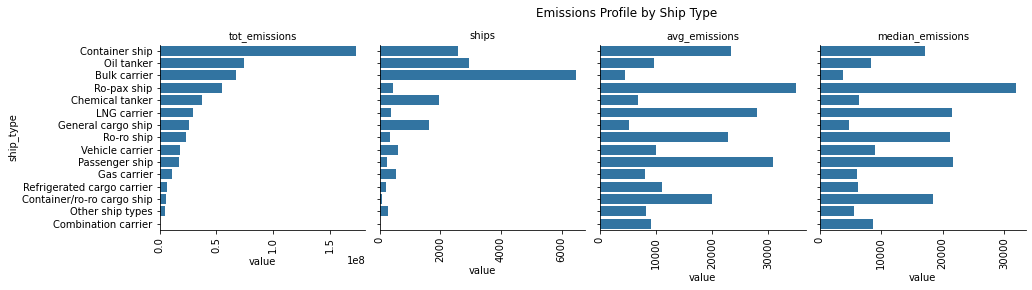

In [14]:
# Pivot to make plot
piv = pd.melt(q2,id_vars = ['ship_type'], value_vars=['tot_emissions', 'ships','avg_emissions','median_emissions'],var_name='metric', value_name='value')

# Plot
g = sns.FacetGrid(piv, col="metric",col_wrap=5,sharex=False,size=3.5)
g.map_dataframe(sns.barplot, x="value",y='ship_type')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Emissions Profile by Ship Type',y=1.05)
[plt.setp(ax.get_xticklabels(), rotation=90,size=10) for ax in g.axes.flat]
plt.show()

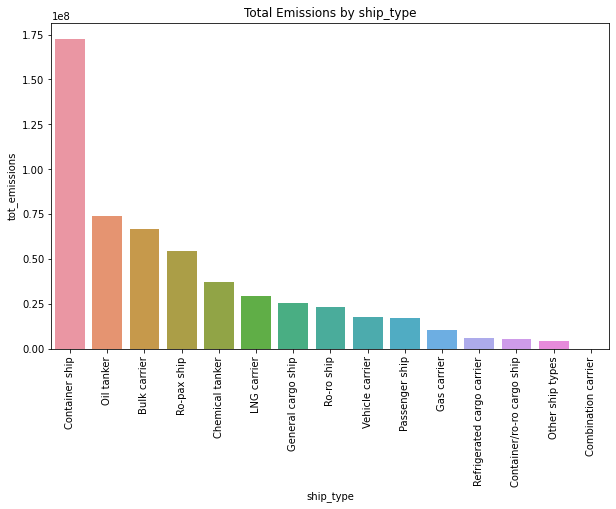

In [15]:
sns.barplot(data=q2,x='ship_type',y='tot_emissions')
plt.xticks(rotation=90,size=10) # tick rotation
plt.title('Total Emissions by ship_type')# add title
plt.show()

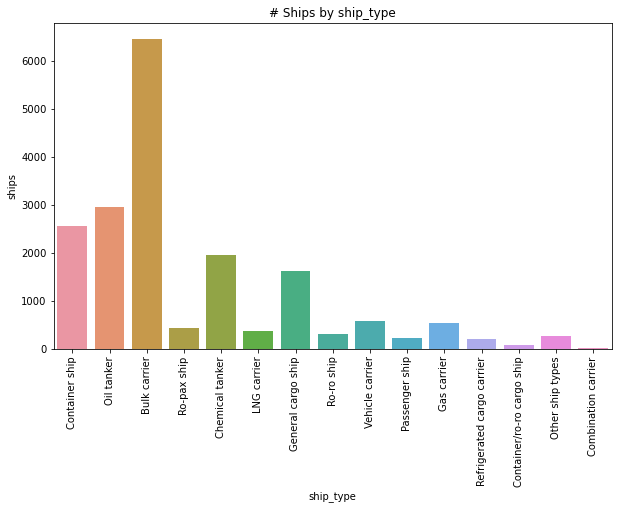

In [16]:
sns.barplot(data=q2,x='ship_type',y='ships')
plt.xticks(rotation=90,size=10) # tick rotation
plt.title('# Ships by ship_type')# add title
plt.show()

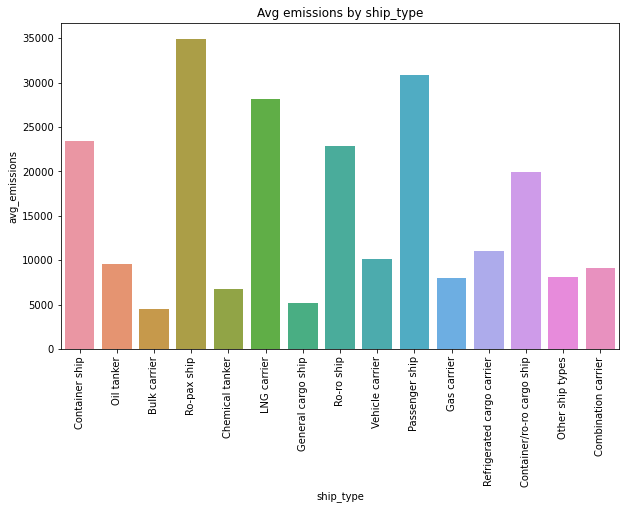

In [17]:
sns.barplot(data=q2,x='ship_type',y='avg_emissions')
plt.xticks(rotation=90,size=10) # tick rotation
plt.title('Avg emissions by ship_type')# add title
plt.show()

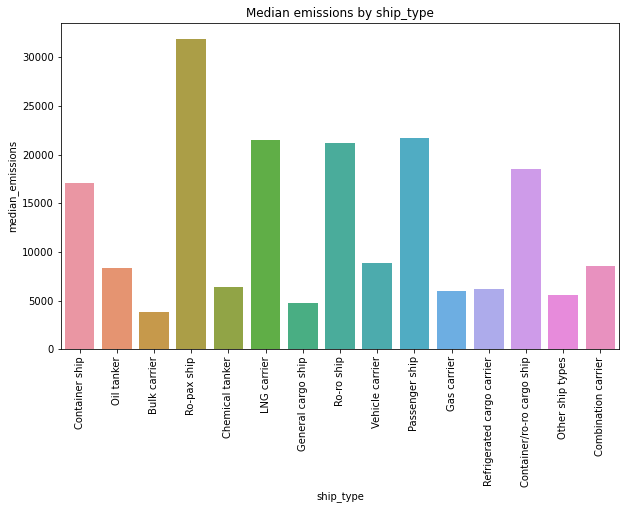

In [18]:
sns.barplot(data=q2,x='ship_type',y='median_emissions')
plt.xticks(rotation=90,size=10) # tick rotation
plt.title('Median emissions by ship_type')# add title
plt.show()

In [19]:
# Extra: Define % of total
q2['share_of_total_emissions'] = q2['tot_emissions'] / q2['tot_emissions'].sum()
q2['share_of_ships'] = q2['ships'] / q2['ships'].sum()
q2.sort_values('tot_emissions',ascending=False)

,ship_type,tot_emissions,ships,avg_emissions,median_emissions,share_of_total_emissions,share_of_ships
0,Container ship,1.727072e+08,2568,23481.607543,17108.480,0.315000,0.137400
1,Oil tanker,7.427222e+07,2950,9644.490161,8302.660,0.135465,0.157838
2,Bulk carrier,6.710636e+07,6462,4549.583415,3809.075,0.122395,0.345746
3,Ro-pax ship,5.485763e+07,441,34941.167503,31912.865,0.100055,0.023596
4,Chemical tanker,3.729476e+07,1969,6816.808905,6433.650,0.068022,0.105350
5,LNG carrier,2.946634e+07,385,28116.740134,21504.360,0.053744,0.020599
6,General cargo ship,2.573461e+07,1633,5225.301503,4717.060,0.046937,0.087373
7,Ro-ro ship,2.327929e+07,325,22912.685610,21206.270,0.042459,0.017389
8,Vehicle carrier,1.819919e+07,588,10099.439778,8912.805,0.033193,0.031461
9,Passenger ship,1.732769e+07,241,30887.140160,21701.610,0.031604,0.012895


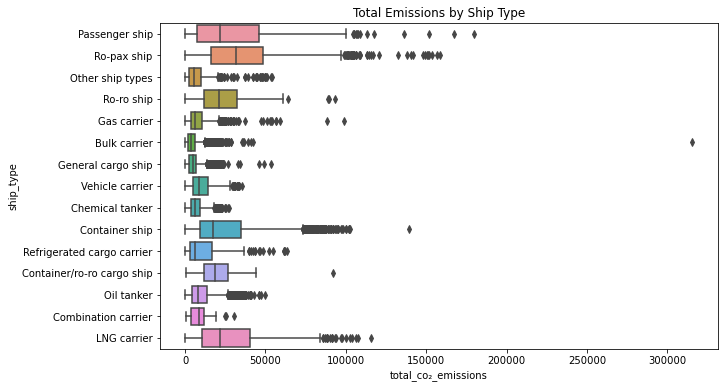

In [20]:
# Set fig size
plt.figure(figsize=(10, 6))
sns.boxplot(data=df,y='ship_type',x='total_co₂_emissions')
plt.yticks(size=10)
plt.title('Total Emissions by Ship Type')
plt.show()

### 2. Emissions Composition

In [21]:
emissions_comp = df[[
    'imo_number',
    'name',
    'ship_type',
    'reporting_period',
    'total_co₂_emissions',
    #composition metrics
    'co₂_emissions_from_all_voyages_between_ports_under_a_ms_jurisdiction',
    'co₂_emissions_from_all_voyages_which_departed_from_ports_under_a_ms_jurisdiction',
    'co₂_emissions_from_all_voyages_to_ports_under_a_ms_jurisdiction',
    'co₂_emissions_which_occurred_within_ports_under_a_ms_jurisdiction_at_berth',
    
]]

# Replace NaNs with 0s where needed to enable math functions
emissions_comp['co₂_emissions_from_all_voyages_between_ports_under_a_ms_jurisdiction'] = emissions_comp['co₂_emissions_from_all_voyages_between_ports_under_a_ms_jurisdiction'].replace(np.nan, 0)
emissions_comp['co₂_emissions_from_all_voyages_which_departed_from_ports_under_a_ms_jurisdiction'] = emissions_comp['co₂_emissions_from_all_voyages_which_departed_from_ports_under_a_ms_jurisdiction'].replace(np.nan, 0)
emissions_comp['co₂_emissions_from_all_voyages_to_ports_under_a_ms_jurisdiction'] = emissions_comp['co₂_emissions_from_all_voyages_to_ports_under_a_ms_jurisdiction'].replace(np.nan, 0)
emissions_comp['co₂_emissions_which_occurred_within_ports_under_a_ms_jurisdiction_at_berth'] = emissions_comp['co₂_emissions_which_occurred_within_ports_under_a_ms_jurisdiction_at_berth'].replace(np.nan, 0)

# Test composition definition
emissions_comp['new_tot'] = emissions_comp['co₂_emissions_from_all_voyages_between_ports_under_a_ms_jurisdiction'] + emissions_comp['co₂_emissions_from_all_voyages_which_departed_from_ports_under_a_ms_jurisdiction'] + emissions_comp['co₂_emissions_from_all_voyages_to_ports_under_a_ms_jurisdiction'] + emissions_comp['co₂_emissions_which_occurred_within_ports_under_a_ms_jurisdiction_at_berth']
emissions_comp['diff'] = emissions_comp['new_tot'] / emissions_comp['total_co₂_emissions']
emissions_comp['diff'].describe([0.01,0.25,0.5,0.75,0.98,0.99])

count    47345.000000
mean         1.014105
std          1.245549
min          0.000000
1%           0.960444
25%          0.999999
50%          1.000000
75%          1.000001
98%          1.000452
99%          1.007647
max        203.115957
Name: diff, dtype: float64

In [22]:
# Remove outliers
emissions_comp = emissions_comp[emissions_comp['diff'] > 0.998]
emissions_comp = emissions_comp[emissions_comp['diff'] < 1.008]  

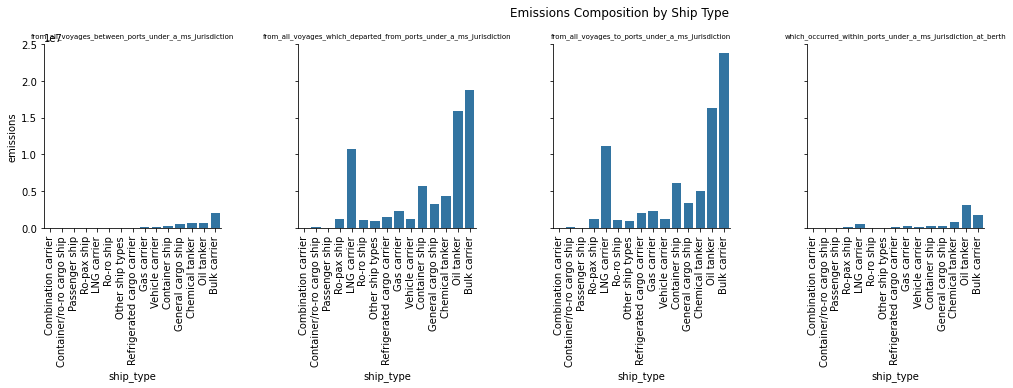

In [23]:
# Transform df from wide to long and plot the facet grid
emissions_comp_agg = emissions_comp[emissions_comp['co₂_emissions_from_all_voyages_between_ports_under_a_ms_jurisdiction'] < 800]

emissions_comp_agg = emissions_comp_agg.groupby('ship_type').agg(from_all_voyages_between_ports_under_a_ms_jurisdiction = ('co₂_emissions_from_all_voyages_between_ports_under_a_ms_jurisdiction','sum'),
                                                                from_all_voyages_which_departed_from_ports_under_a_ms_jurisdiction = ('co₂_emissions_from_all_voyages_which_departed_from_ports_under_a_ms_jurisdiction','sum'),
                                                                from_all_voyages_to_ports_under_a_ms_jurisdiction = ('co₂_emissions_from_all_voyages_to_ports_under_a_ms_jurisdiction','sum'),
                                                                which_occurred_within_ports_under_a_ms_jurisdiction_at_berth = ('co₂_emissions_which_occurred_within_ports_under_a_ms_jurisdiction_at_berth','sum')).sort_values('from_all_voyages_between_ports_under_a_ms_jurisdiction').reset_index()
# Pivot to make plot
piv = pd.melt(emissions_comp_agg,id_vars = ['ship_type'], value_vars=['from_all_voyages_between_ports_under_a_ms_jurisdiction', 'from_all_voyages_which_departed_from_ports_under_a_ms_jurisdiction','from_all_voyages_to_ports_under_a_ms_jurisdiction','which_occurred_within_ports_under_a_ms_jurisdiction_at_berth'],var_name='source', value_name='emissions')

# Plot pivot
g = sns.FacetGrid(piv, col="source",col_wrap=5,sharex=False,size=3.5)
g.map_dataframe(sns.barplot, x="ship_type",y='emissions')
g.set_titles(col_template="{col_name}",size=7)
g.fig.suptitle('Emissions Composition by Ship Type',y=1.05)
[plt.setp(ax.get_xticklabels(), rotation=90,size=10) for ax in g.axes.flat]
plt.show()

### 3. Emissions Efficiency & Intensity

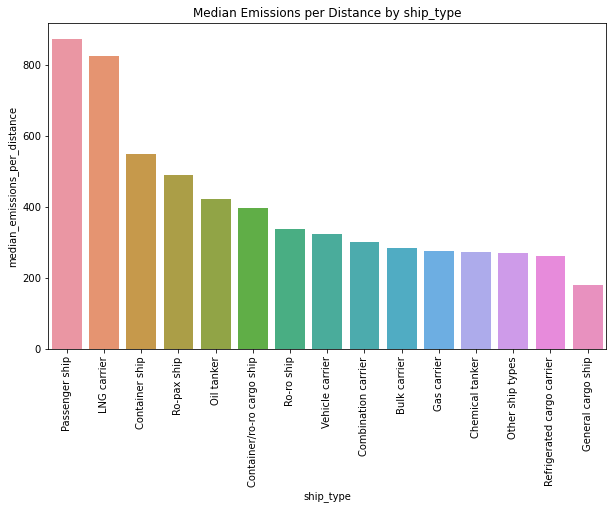

In [24]:
# Cast emissions intensity metric as a float
df['annual_average_co₂_emissions_per_distance'] = pd.to_numeric(df['annual_average_co₂_emissions_per_distance'], errors='coerce')

tmp = df.groupby('ship_type').agg(median_emissions_per_distance = ('annual_average_co₂_emissions_per_distance','median')).sort_values('median_emissions_per_distance',ascending=False).reset_index()
sns.barplot(data=tmp,x='ship_type',y='median_emissions_per_distance')
plt.xticks(rotation=90,size=10) # tick rotation
plt.title('Median Emissions per Distance by ship_type')# add title
plt.show()

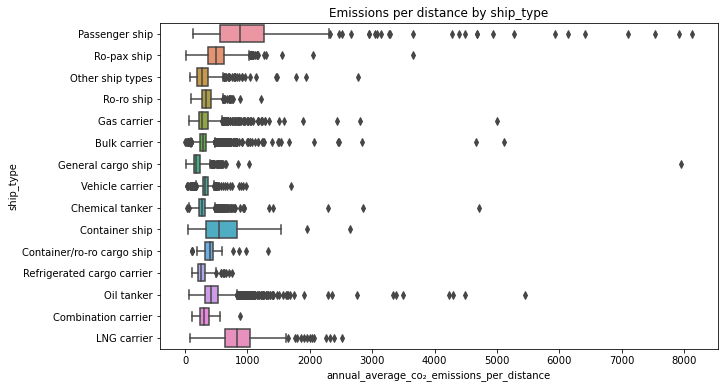

In [25]:
# Remove outlier
tmp = df[df['annual_average_co₂_emissions_per_distance'] < 10000]
# Set fig size
plt.figure(figsize=(10, 6))
sns.boxplot(data=tmp,y='ship_type',x='annual_average_co₂_emissions_per_distance')
plt.yticks(size=10)
plt.title('Emissions per distance by ship_type')
plt.show()

### Emissions Intensity

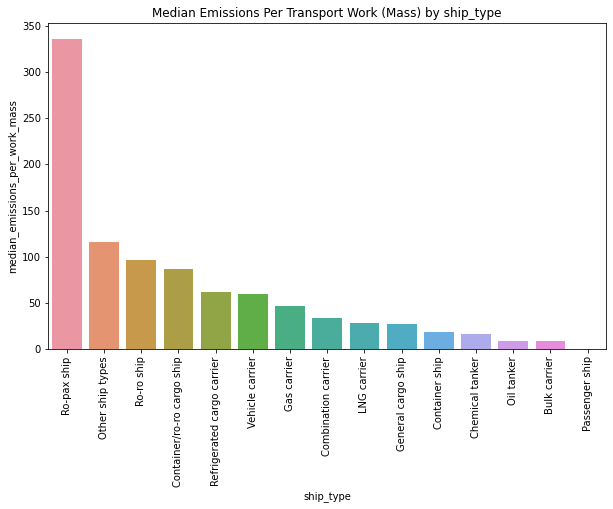

In [26]:
df['annual_average_co₂_emissions_per_transport_work_(mass)'] = pd.to_numeric(df['annual_average_co₂_emissions_per_transport_work_(mass)'], errors='coerce')

tmp = df.groupby('ship_type').agg(median_emissions_per_work_mass = ('annual_average_co₂_emissions_per_transport_work_(mass)','median')).sort_values('median_emissions_per_work_mass',ascending=False).reset_index()
sns.barplot(data=tmp,x='ship_type',y='median_emissions_per_work_mass')
plt.xticks(rotation=90,size=10) # tick rotation
plt.title('Median Emissions Per Transport Work (Mass) by ship_type')# add title
plt.show()

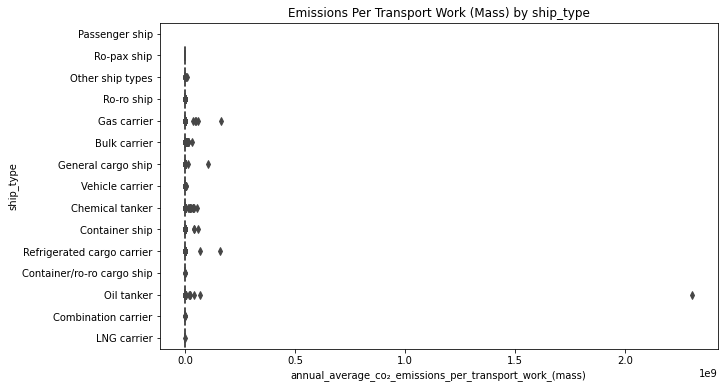

In [27]:
# Set fig size
plt.figure(figsize=(10, 6))
sns.boxplot(data=df,y='ship_type',x='annual_average_co₂_emissions_per_transport_work_(mass)')
plt.yticks(size=10)
plt.title('Emissions Per Transport Work (Mass) by ship_type')
plt.show()

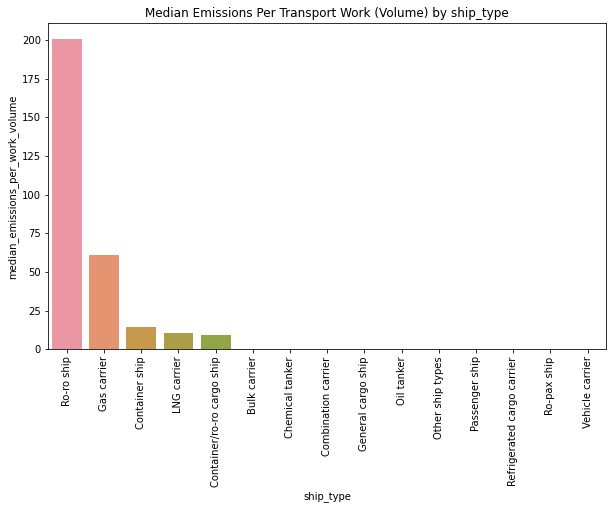

In [28]:
df['annual_average_co₂_emissions_per_transport_work_(volume)'] = pd.to_numeric(df['annual_average_co₂_emissions_per_transport_work_(volume)'], errors='coerce')

tmp = df.groupby('ship_type').agg(median_emissions_per_work_volume = ('annual_average_co₂_emissions_per_transport_work_(volume)','median')).sort_values('median_emissions_per_work_volume',ascending=False).reset_index()
sns.barplot(data=tmp,x='ship_type',y='median_emissions_per_work_volume')
plt.xticks(rotation=90,size=10) # tick rotation
plt.title('Median Emissions Per Transport Work (Volume) by ship_type') # add title
plt.show()

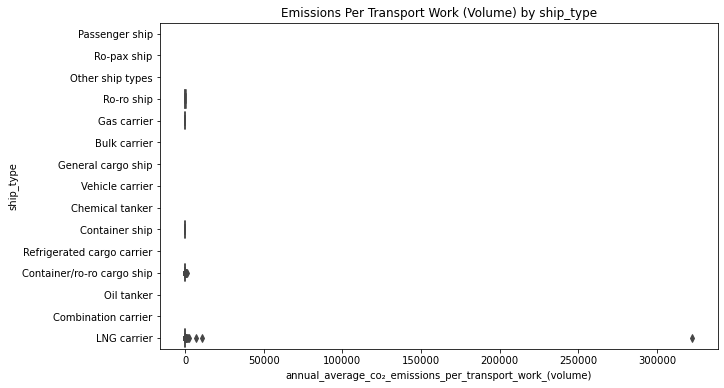

In [29]:
# Set fig size
plt.figure(figsize=(10, 6))
sns.boxplot(data=df,y='ship_type',x='annual_average_co₂_emissions_per_transport_work_(volume)')
plt.yticks(size=10)
plt.title('Emissions Per Transport Work (Volume) by ship_type')
plt.show()

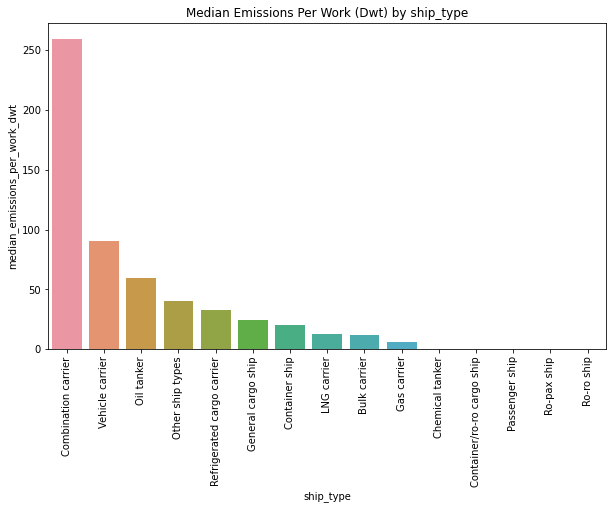

In [30]:
df['annual_average_co₂_emissions_per_transport_work_(dwt)'] = pd.to_numeric(df['annual_average_co₂_emissions_per_transport_work_(dwt)'], errors='coerce')

tmp = df.groupby('ship_type').agg(median_emissions_per_work_dwt = ('annual_average_co₂_emissions_per_transport_work_(dwt)','median')).sort_values('median_emissions_per_work_dwt',ascending=False).reset_index()
sns.barplot(data=tmp,x='ship_type',y='median_emissions_per_work_dwt')
plt.xticks(rotation=90,size=10) # tick rotation
plt.title('Median Emissions Per Work (Dwt) by ship_type')# add title
plt.show()

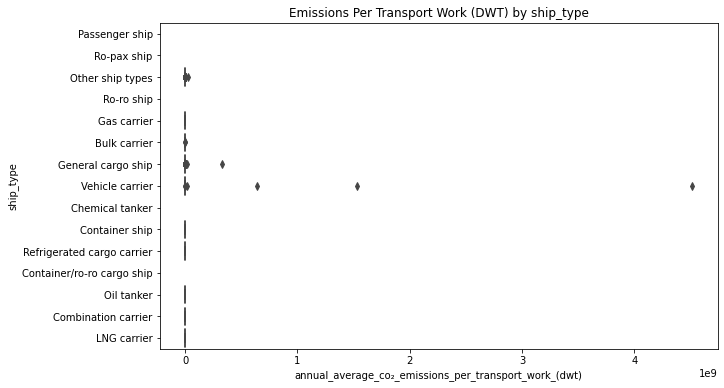

In [31]:
# Set fig size
plt.figure(figsize=(10, 6))
sns.boxplot(data=df,y='ship_type',x='annual_average_co₂_emissions_per_transport_work_(dwt)')
plt.yticks(size=10)
plt.title('Emissions Per Transport Work (DWT) by ship_type')
plt.show()

## Q3: What is the relationship between ship Deadweight and emissions intensity?

**Method**
* Define deadweight and emissions intensity terms
* Check data coverage
* Remove outliers
* Check for trends
* Transform as log and run controlled regression

**Takeaways**
* **Every 1 unit increase in dwt leads to a 0.007 decrease in emissions intensity (p < 0.000).**

From [this Carbon Chain article](https://www.carbonchain.com/blog/understand-your-shipping-emissions), emissions intensity seems to correspond to the column **'annual_average_co₂_emissions_per_transport_work_(dwt)'**.

Deadweight (dwt) is a component of this ratio, so we can isolate that variable to complete the analysis.

First, emissions intensity data is missing from 88% of the database, so the scope of this analysis is limited.

#### Data cleaning

In [32]:
# Check coverage for emissions intensity metric
missing_values[missing_values['column_name'] == 'annual_average_co₂_emissions_per_transport_work_(dwt)']

,column_name,percent_missing
23,annual_average_co₂_emissions_per_transport_wor...,88.331055


In [33]:
# Create df that has a dwt value
df_dwt = df[df['annual_average_co₂_emissions_per_transport_work_(dwt)'].notnull()]

# Check remaining coverage
df_dwt.groupby('annual_average_co₂_emissions_per_transport_work_(dwt)').agg(count = ('imo_number','count')).sort_values('count',ascending=False)

,count
annual_average_co₂_emissions_per_transport_work_(dwt),
2.022000e+01,8
2.186000e+01,8
1.815000e+01,6
2.425000e+01,6
2.424000e+01,6
...,...
2.602000e+01,1
2.601000e+01,1
2.596000e+01,1


In [34]:
# Cast emissions intensity metric as a float
df_dwt['annual_average_co₂_emissions_per_transport_work_(dwt)'] = pd.to_numeric(df_dwt['annual_average_co₂_emissions_per_transport_work_(dwt)'], errors='coerce')

# Rerun coverage check after transformation
df_dwt.groupby('annual_average_co₂_emissions_per_transport_work_(dwt)').agg(count = ('imo_number','count')).sort_values('count',ascending=False)

,count
annual_average_co₂_emissions_per_transport_work_(dwt),
2.022000e+01,8
2.186000e+01,8
1.815000e+01,6
2.425000e+01,6
2.424000e+01,6
...,...
2.602000e+01,1
2.601000e+01,1
2.596000e+01,1


#### Data Transformations

In [35]:
# Define deadweight (dwt) as (total emissions * 1000 * 1000 * nautical miles) / emissions intensity

# Calculate nautical miles as (total * 1000) / (total/distance)
df_dwt['n_miles'] = df_dwt['total_co₂_emissions'] * 1000 / df_dwt['annual_average_co₂_emissions_per_distance']

# Declare dwt by isolating it from the ratio metric
# Multiply by (1000 * 1000) to convert from metric tonnes to grams of co2
df_dwt['dwt'] = (df_dwt['total_co₂_emissions'] * 1000 * 1000 / df_dwt['n_miles']) / df_dwt['annual_average_co₂_emissions_per_transport_work_(dwt)']

# Declare emissions intensity metric, which is the ratio metric, for ease of use
df_dwt['emissions_intensity'] = df_dwt['annual_average_co₂_emissions_per_transport_work_(dwt)']

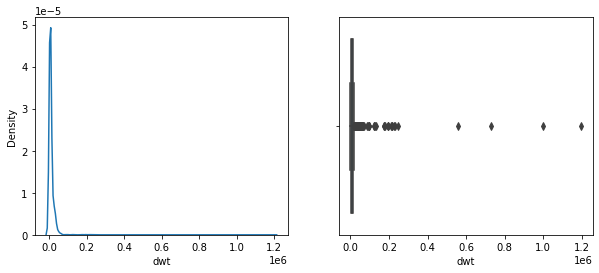

In [36]:
# Plot KDE and boxplot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
sns.kdeplot(data=df_dwt, x='dwt', ax=ax[0])
sns.boxplot(data=df_dwt, x='dwt', ax=ax[1])
plt.show()

<AxesSubplot:xlabel='emissions_intensity'>

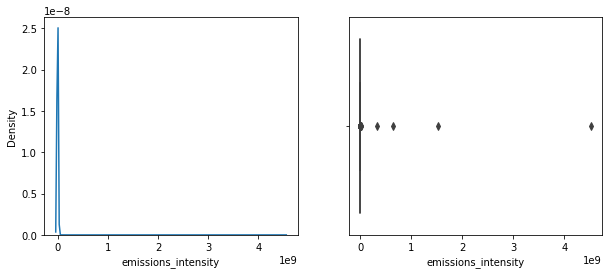

In [37]:
# Plot KDE and boxplot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
sns.kdeplot(data=df_dwt, x='emissions_intensity', ax=ax[0])
sns.boxplot(data=df_dwt, x='emissions_intensity', ax=ax[1])

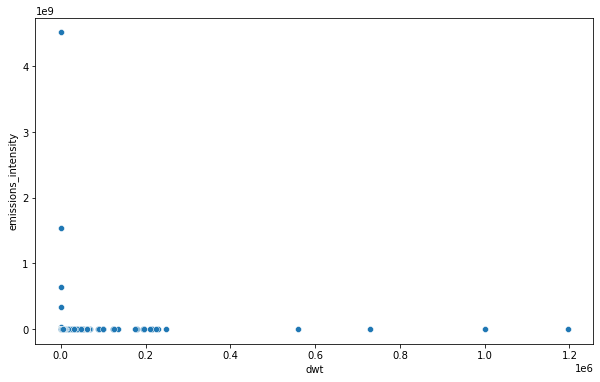

In [38]:
# Plot scatterplot to see relationship
sns.scatterplot(data=df_dwt,x='dwt',y='emissions_intensity')
plt.show()

#### Removing Outliers

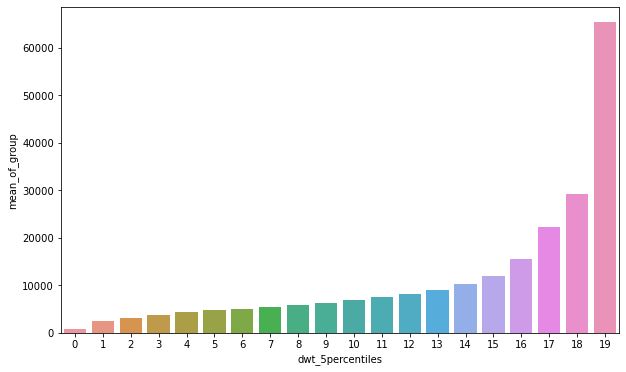

In [39]:
# Define percentiles
df_dwt['dwt_5percentiles'] = pd.qcut(df_dwt['dwt'], 20, labels=False)

# Plot average of groups to check for outlier cutoffs 
tmp = df_dwt.groupby('dwt_5percentiles').agg(mean_of_group = ('dwt','mean')).reset_index()
sns.barplot(data = tmp, x = 'dwt_5percentiles', y = 'mean_of_group')
plt.show()

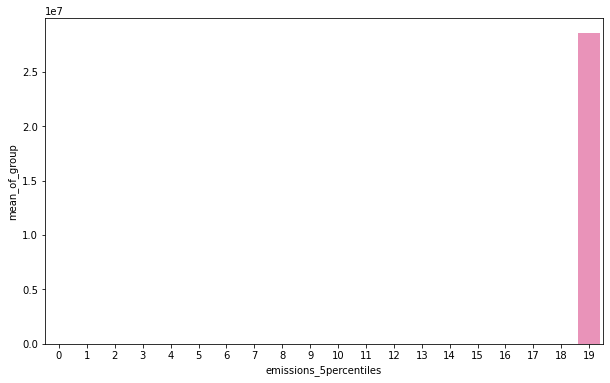

In [40]:
# Define percentiles
df_dwt['emissions_5percentiles'] = pd.qcut(df_dwt['emissions_intensity'], 20, labels=False)

# Plot average of groups to check for outlier cutoffs
tmp = df_dwt.groupby('emissions_5percentiles').agg(mean_of_group = ('emissions_intensity','mean')).reset_index()
sns.barplot(data = tmp, x = 'emissions_5percentiles', y = 'mean_of_group')
plt.show()

In [41]:
# Remove top 5% of entries for each metric
df_dwt = df_dwt[df_dwt['dwt_5percentiles'] <= 18] 
df_dwt = df_dwt[df_dwt['emissions_5percentiles'] <= 18]

#### Distributions (without outliers)

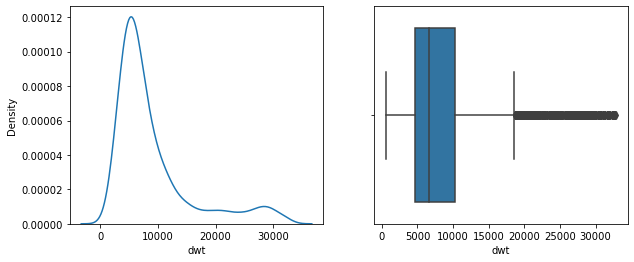

In [42]:
# Plot KDE and boxplot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
sns.kdeplot(data=df_dwt, x='dwt', ax=ax[0])
sns.boxplot(data=df_dwt, x='dwt', ax=ax[1])
plt.show()

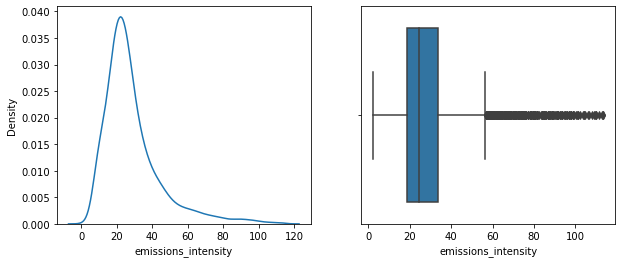

In [43]:
# Plot KDE and boxplot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
sns.kdeplot(data=df_dwt, x='emissions_intensity', ax=ax[0])
sns.boxplot(data=df_dwt, x='emissions_intensity', ax=ax[1])
plt.show()

### Trends

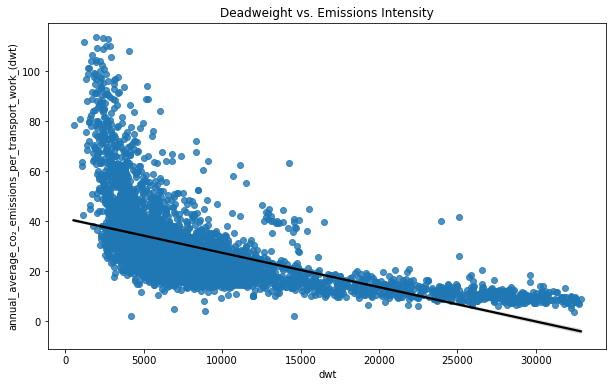

In [44]:
# Regression plot
sns.regplot(data=df_dwt,x = 'dwt',y='annual_average_co₂_emissions_per_transport_work_(dwt)',fit_reg=True, line_kws={"color": "black"})
plt.title("Deadweight vs. Emissions Intensity")
plt.show()

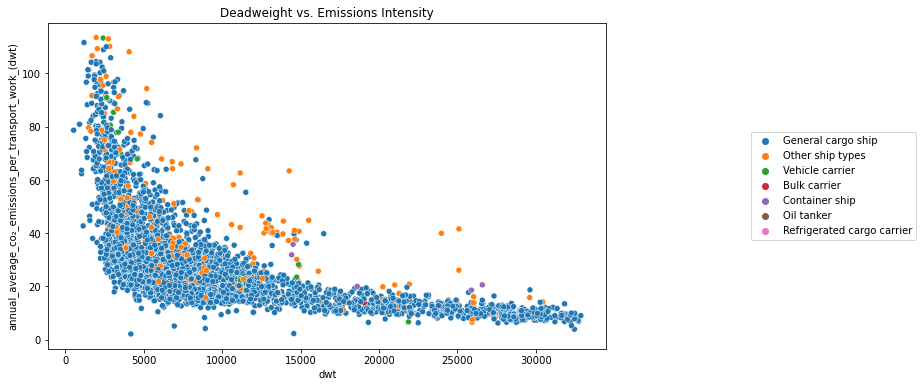

In [45]:
g = sns.scatterplot(data=df_dwt,x='dwt',y='annual_average_co₂_emissions_per_transport_work_(dwt)',hue = 'ship_type')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title("Deadweight vs. Emissions Intensity")
plt.show()

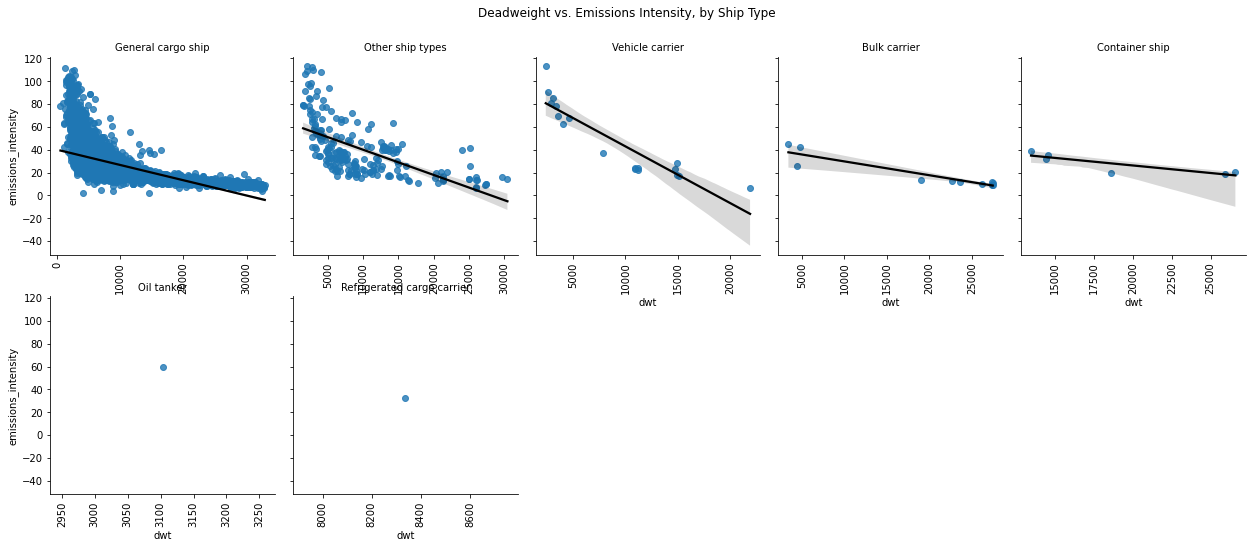

In [46]:
# Plot
g = sns.FacetGrid(df_dwt, col="ship_type",col_wrap=5,sharex=False,size=3.5)
g.map_dataframe(sns.regplot,x = 'dwt',y='emissions_intensity',fit_reg=True, line_kws={"color": "black"})
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Deadweight vs. Emissions Intensity, by Ship Type',y=1.05)
[plt.setp(ax.get_xticklabels(), rotation=90,size=10) for ax in g.axes.flat]
plt.show()

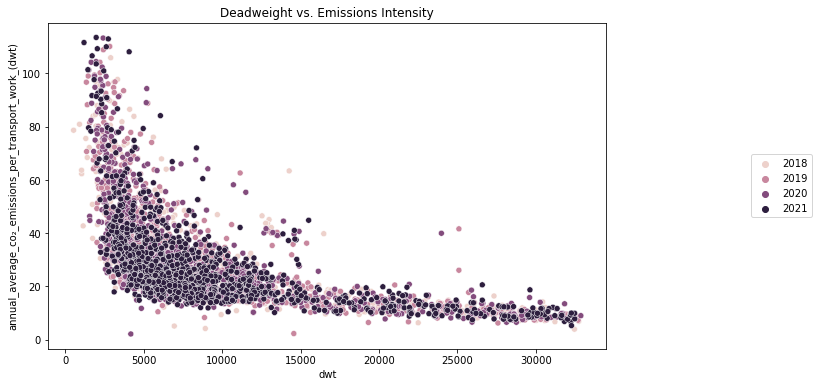

In [47]:
g = sns.scatterplot(data=df_dwt,x='dwt',y='annual_average_co₂_emissions_per_transport_work_(dwt)',hue = 'reporting_period')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title("Deadweight vs. Emissions Intensity")
plt.show()

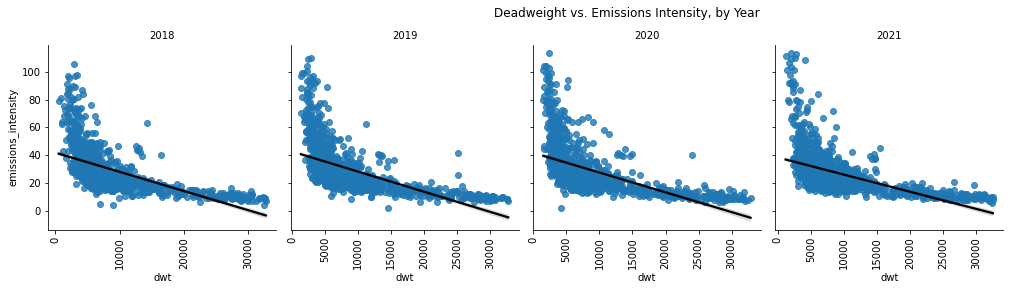

In [48]:
# Plot
g = sns.FacetGrid(df_dwt, col="reporting_period",col_wrap=5,sharex=False,size=3.5)
g.map_dataframe(sns.regplot,x = 'dwt',y='emissions_intensity',fit_reg=True, line_kws={"color": "black"})
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Deadweight vs. Emissions Intensity, by Year',y=1.05)
[plt.setp(ax.get_xticklabels(), rotation=90,size=10) for ax in g.axes.flat]
plt.show()

#### Log of emissions will add linearity for model purposes

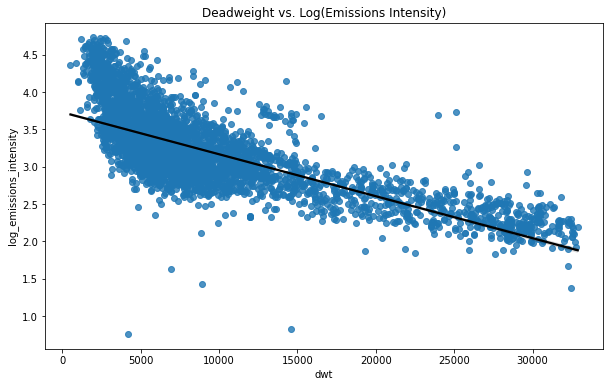

In [49]:
df_dwt['log_emissions_intensity'] = np.log(df_dwt['emissions_intensity'])

# Plot
sns.regplot(data=df_dwt,x = 'dwt',y='log_emissions_intensity',fit_reg=True, line_kws={"color": "black"})
plt.title("Deadweight vs. Log(Emissions Intensity)")
plt.show()

#### Naive Regression

In [50]:
# # Define independent variable set
x = df_dwt['dwt']

# Add constant
x = sm.add_constant(x)

# Define dependent variable
y = df_dwt['log_emissions_intensity']

# Run OLS model
model_lm = sm.OLS(y, x).fit()
print_model = model_lm.summary()
print(print_model)

                               OLS Regression Results                              
Dep. Variable:     log_emissions_intensity   R-squared:                       0.554
Model:                                 OLS   Adj. R-squared:                  0.554
Method:                      Least Squares   F-statistic:                     5547.
Date:                     Sun, 15 Oct 2023   Prob (F-statistic):               0.00
Time:                             23:34:09   Log-Likelihood:                -1576.9
No. Observations:                     4464   AIC:                             3158.
Df Residuals:                         4462   BIC:                             3171.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

#### Controlled Regression

In [51]:
x = df_dwt[['dwt','annual_total_time_spent_at_sea','verifier_country','ship_type','reporting_period','total_co₂_emissions','n_miles']]

# Make dummies for categorical variables
x = pd.get_dummies(x,
                     columns = ['verifier_country','ship_type','reporting_period'])

# Add constant
x = sm.add_constant(x)

# Define dependent variable
y = df_dwt['log_emissions_intensity']

# Run OLS model
model_lm = sm.OLS(y, x).fit()
print_model = model_lm.summary()
print(print_model)

                               OLS Regression Results                              
Dep. Variable:     log_emissions_intensity   R-squared:                       0.732
Model:                                 OLS   Adj. R-squared:                  0.730
Method:                      Least Squares   F-statistic:                     576.7
Date:                     Sun, 15 Oct 2023   Prob (F-statistic):               0.00
Time:                             23:34:09   Log-Likelihood:                -444.13
No. Observations:                     4464   AIC:                             932.3
Df Residuals:                         4442   BIC:                             1073.
Df Model:                               21                                         
Covariance Type:                 nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

## Q4: How many miles did each vessel in the database travel?

**Method**
* Repurpose miles definition from task 3
* Spot check case examples for intuitive sense
* Aggregate miles for the same vessels over time
 
**Takeaways**
* 1.3 billion miles traveled in total
* Avg ship’s mileage: 66,868 miles
* Top 8 highest-mileage ships were registered in Italy – is this an important node in the global shipping ecosystem?

#### Data Transformations

In [52]:
# Must first define nautical miles  = total emissions * 1000 / (total emissions / miles)
# Cast ratio metric as a float
df['annual_average_co₂_emissions_per_distance'] = pd.to_numeric(df['annual_average_co₂_emissions_per_distance'], errors='coerce')
# Calculate nautical miles as (total * 1000) / (total/distance)
df['n_miles'] = df['total_co₂_emissions'] * 1000 / df['annual_average_co₂_emissions_per_distance']


#df_tmp = df.sort_values('n_miles',ascending=True).head(1)
df_tmp = df[['imo_number','reporting_period','name','total_co₂_emissions','annual_average_co₂_emissions_per_distance','n_miles']].sort_values('n_miles',ascending=True)

#### Spot Checks

Very large average (emissions/distance) should have very small distances.

Very small average (emissions/distance) should have very large distances.

There should be a positive relationship between miles traveled and time spent at sea.

In [53]:
df_tmp.head(3)

,imo_number,reporting_period,name,total_co₂_emissions,annual_average_co₂_emissions_per_distance,n_miles
37420,9145413,2021,ICARUS III,2305.78,2305780.00,1.000000
23829,9782314,2019,ILEKTRA,2598.01,202022.51,12.860003
30839,9464522,2020,GLORY DINA,4074.61,200423.59,20.329992


In [54]:
df_tmp = df_tmp[df_tmp['n_miles'].notnull()]
df_tmp.tail(3)

,imo_number,reporting_period,name,total_co₂_emissions,annual_average_co₂_emissions_per_distance,n_miles
4495,9351505,2018,CRUISE OLYMPIA,156495.22,946.31,165374.158574
2095,9244116,2018,EUROPEAN HIGHLANDER,51546.31,310.19,166176.569200
2803,9285641,2018,MORNING CROWN,14971.56,47.73,313671.904463


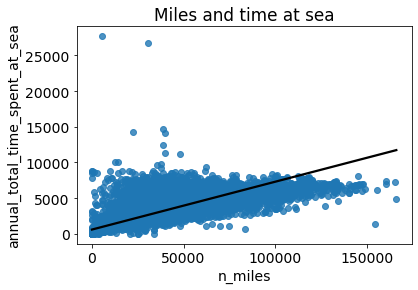

In [55]:
# Plot
plt.rc("figure", figsize=(6, 4))
plt.rc("font", size=14)
df_reg = df[df['annual_total_time_spent_at_sea'] < 30000] # Filter out outliers
df_reg = df_reg[df_reg['n_miles'] < 250000] # Filter out outliers
sns.regplot(data=df_reg,x = 'n_miles',y='annual_total_time_spent_at_sea',fit_reg=True, line_kws={"color": "black"})
plt.title('Miles and time at sea')
plt.show()

* Extreme cases fit our expectations
* Miles is positively correlated with time at sea, as expected

### Aggregate miles per vessel (over time)

In [56]:
q4_df = df.groupby(['imo_number','name','verifier_country']).agg(miles = ('n_miles','sum')).sort_values('miles', ascending=False).reset_index()
q4_df.head(10)

,imo_number,name,verifier_country,miles
0,9336268,FINNLADY,Italy,584721.438625
1,9319466,FINNMAID,Italy,576432.598640
2,9319442,FINNSTAR,Italy,569934.143277
3,9351490,CRUISE EUROPA,Italy,537277.666834
4,9216030,HELLENIC SPIRIT,Italy,528559.210068
5,9351488,CRUISE BARCELONA,Italy,515993.907995
6,9351476,CRUISE ROMA,Italy,512346.327610
7,9216028,OLYMPIC CHAMPION,Italy,510419.375391
8,9198927,CAP FINISTERE,France,484738.200165
9,9187318,L'AUDACE,France,472132.763981


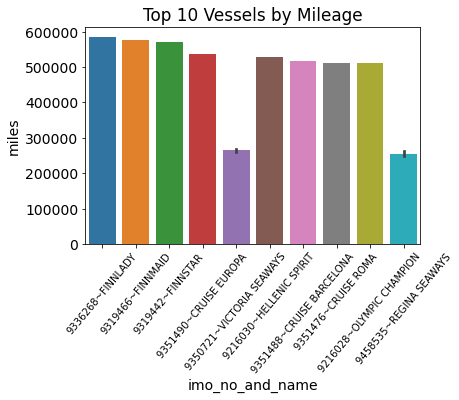

In [57]:
q4_df['imo_no_and_name'] = q4_df['imo_number'].apply(str) + '~' + q4_df['name'].apply(str)
top_10 = q4_df.groupby(['imo_no_and_name'])['miles'].sum().sort_values(ascending=False).head(10)

# Plot
sns.barplot(data=q4_df,x = 'imo_no_and_name',y='miles', order=top_10.index)
plt.xticks(rotation=50,size=10) # tick marks
plt.title('Top 10 Vessels by Mileage')# plot title
#plt.bar_label(ax.containers[0]) # plot bar labels
plt.show()

In [58]:
q4_df['miles'].describe()

count     23425.000000
mean      57108.242144
std       63101.301064
min           0.000000
25%       15451.133890
50%       34890.977430
75%       74434.881436
max      584721.438625
Name: miles, dtype: float64

In [59]:
q4_df['miles'].sum()

1337760572.2151299

# Extra Facts

## Emissions Correlations

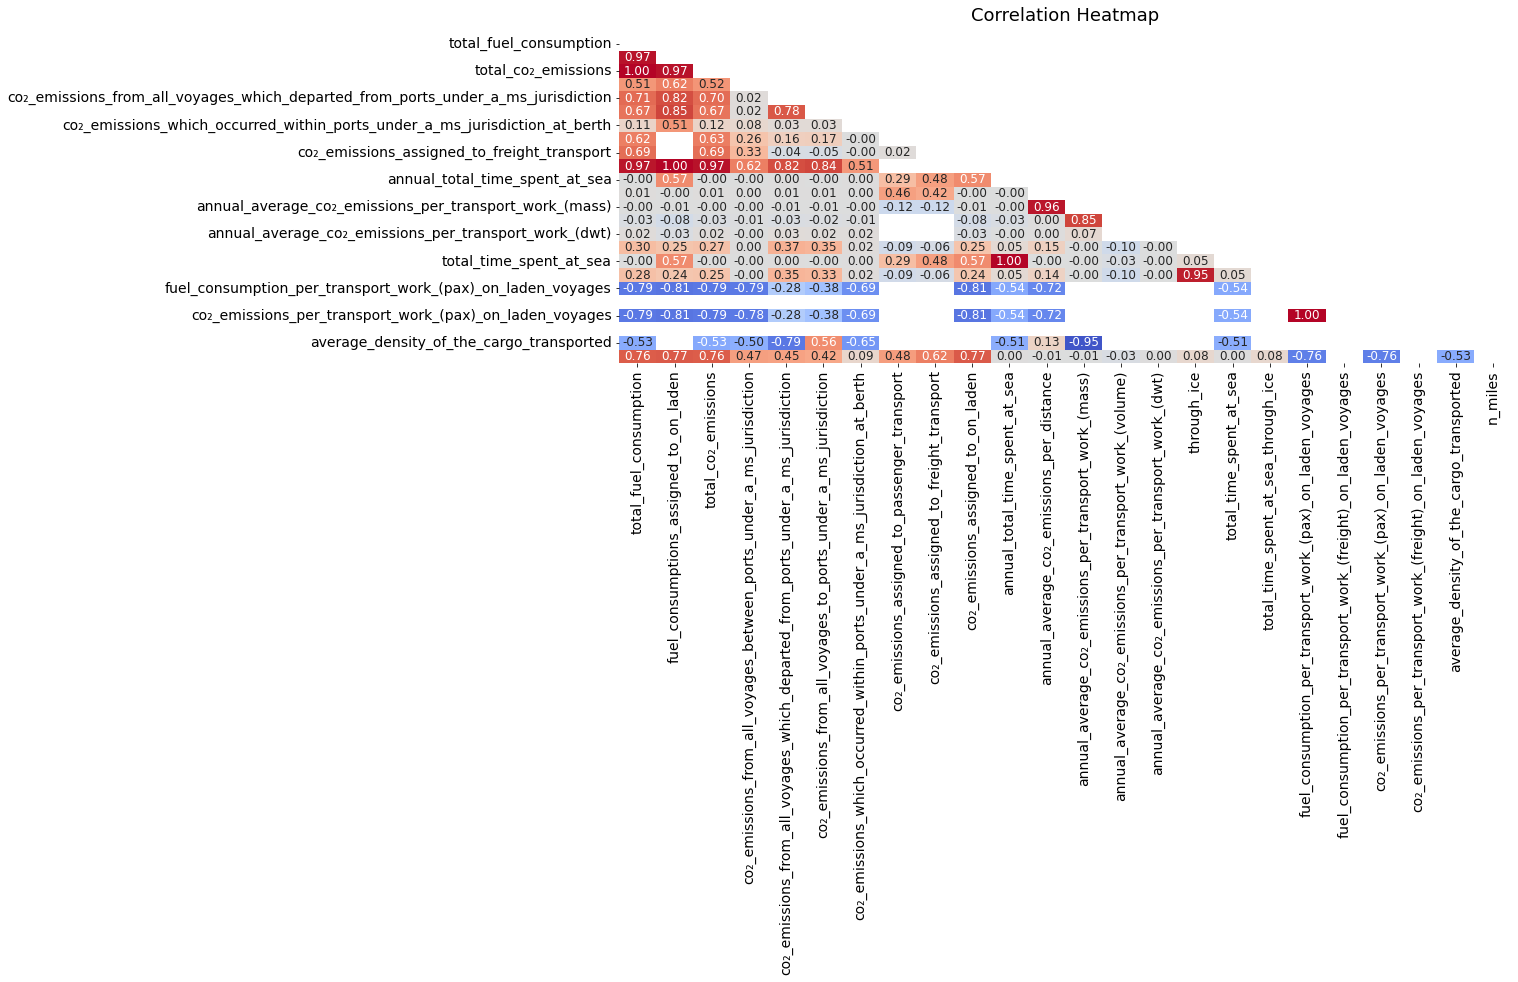

In [60]:
# Make a heatmap df by dropping categorical variables and non-relevant data points
df_hm = df.drop(['imo_number','name','ship_type','reporting_period'],axis=1)

# Set fig size
plt.figure(figsize=(16, 6))

# Define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_hm.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_hm.corr(), mask=mask, vmin=-1, vmax=1, annot=True,fmt=".002f",annot_kws={"size": 12}, cmap='coolwarm', cbar=False) 
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
plt.show()

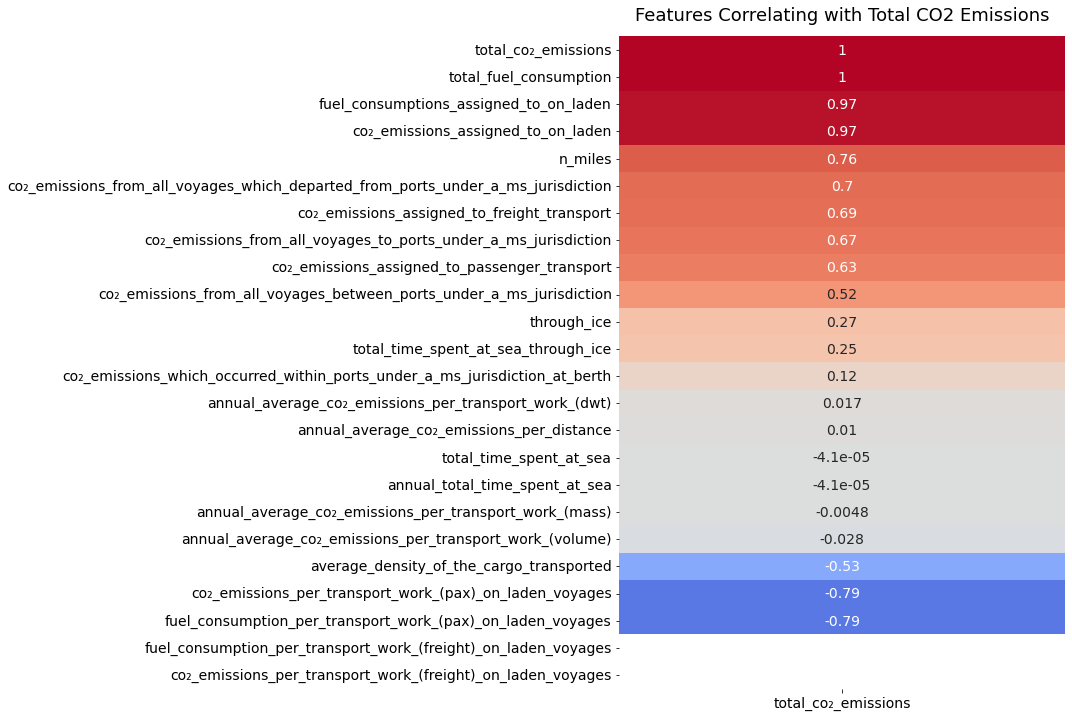

In [61]:
# Filter just for 'points' correlates
df_hm.corr()[['total_co₂_emissions']].sort_values(by='total_co₂_emissions', ascending=False)

# Set fig size
plt.figure(figsize=(8, 12))

# Plot 
heatmap = sns.heatmap(df_hm.corr()[['total_co₂_emissions']].sort_values(by='total_co₂_emissions', ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm',cbar=False)
heatmap.set_title('Features Correlating with Total CO2 Emissions', fontdict={'fontsize':18}, pad=16)
plt.show()

In [62]:
df['emissions_consumption_ratio'] = df['total_co₂_emissions'] / df['total_fuel_consumption']
df['emissions_consumption_ratio'].describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count    47346.000000
mean         3.137154
std          0.172232
min          0.000000
1%           2.774163
5%           3.115246
10%          3.118199
25%          3.124534
50%          3.135318
75%          3.155187
90%          3.170141
95%          3.194637
99%          3.206002
max         30.092171
Name: emissions_consumption_ratio, dtype: float64